In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
train_targets.shape

(404,)

In [4]:
test_data.shape

(102, 13)

In [5]:
test_targets.shape

(102,)

In [6]:
train_data[0]

array([   1.23247,    0.     ,    8.14   ,    0.     ,    0.538  ,
          6.142  ,   91.7    ,    3.9769 ,    4.     ,  307.     ,
         21.     ,  396.9    ,   18.72   ])

### Feature-wise normalization (normalizing the data)

In [7]:
# for each feature in the data (each of the 13 columns),
# substract the mean of the feature and divide by the
# standard deviation so that the feature will be centered
# around zero and will have a unit standard deviation.

mean = train_data.mean(axis=0)
mean

array([  3.74511057e+00,   1.14801980e+01,   1.11044307e+01,
         6.18811881e-02,   5.57355941e-01,   6.26708168e+00,
         6.90106436e+01,   3.74027079e+00,   9.44059406e+00,
         4.05898515e+02,   1.84759901e+01,   3.54783168e+02,
         1.27408168e+01])

In [8]:
len(mean)

13

In [9]:
train_data -= mean

In [10]:
standard_deviation = train_data.std(axis=0)
standard_deviation

array([  9.22929073e+00,   2.37382770e+01,   6.80287253e+00,
         2.40939633e-01,   1.17147847e-01,   7.08908627e-01,
         2.79060634e+01,   2.02770050e+00,   8.68758849e+00,
         1.66168506e+02,   2.19765689e+00,   9.39946015e+01,
         7.24556085e+00])

In [11]:
len(standard_deviation)

13

In [12]:
train_data /= standard_deviation

In [13]:
# now do the same with the test data
test_data -= mean
test_data /= standard_deviation
# Note: the quantities that we use for normalizing the test data have been computed
# using the training data. We should never use in our workflow any quantity computed on
# the test data, even for something as simple as preprocessing.

In [14]:
train_data.shape

(404, 13)

In [15]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

### Model definition

In [37]:
from keras import models
from keras.layers import Input, Dense

def build_model():
    inputs = Input(shape=(train_data.shape[1],))
    hidden1 = Dense(64, activation='relu')(inputs)
     # network ends with a single unit (for regression), not limited by an activation function
    outputs = Dense(1)(hidden1)
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # loss function is the mean squared error and the metric is the mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### K-fold validation

In [38]:
import numpy as np

k = 4
print('k = ', k)
num_val_samples = len(train_data) // k
print('num_val_samples = ', num_val_samples)
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # prepare the validation data: data for partition # k
    lower = i * num_val_samples
    higher = (i + 1) * num_val_samples
    val_data = train_data[lower:higher]
    val_targets = train_targets[lower:higher]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:lower], train_data[higher:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:lower], train_targets[higher:]], axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    # train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=100, batch_size=1, verbose=0)
    # evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

k =  4
num_val_samples =  101
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [39]:
all_scores

[1.839559252899472, 2.3686558917017266, 2.4843281755352966, 2.405120301364672]

In [40]:
np.mean(all_scores)

2.2744159053752919

### Saving validation logs for each fold 

In [43]:
import numpy as np

k = 4
print('k = ', k)
num_val_samples = len(train_data) // k
print('num_val_samples = ', num_val_samples)
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # prepare the validation data: data from partition #k
    lower = i * num_val_samples
    higher = (i + 1) * num_val_samples
    val_data = train_data[lower:higher]
    val_targets = train_targets[lower:higher]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:lower], train_data[higher:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:lower], train_targets[higher:]], axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=500, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

k =  4
num_val_samples =  101
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [47]:
len(all_mae_histories)

4

In [49]:
len(all_mae_histories[0])

500

In [51]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(len(all_mae_histories[0]))]
len(average_mae_history)

500

In [52]:
average_mae_history[0]

14.557749415978346

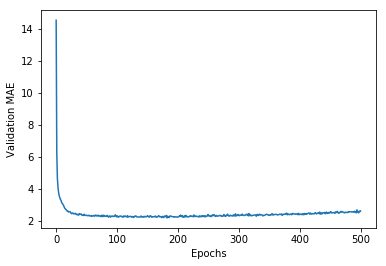

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(average_mae_history)), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
